In [55]:
import json
import numpy as np
import pandas as pd
from scipy import signal
from matplotlib import pyplot as plt
import glob
from datetime import datetime, timedelta
import pdb
import os

%matplotlib inline

In [56]:


import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
from scipy.interpolate import griddata
from cycler import cycler

from pandas.plotting import register_matplotlib_converters
import datetime
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.ticker import Formatter
import matplotlib.dates as mdates



### MATPLOTLIBRC FORMAT
#mpl.rcParams['backend'] = 'MacOSX'

# LINES
mpl.rcParams['lines.linewidth'] = 2.0     # line width in points
mpl.rcParams['lines.dash_capstyle'] = 'round'          # butt|round|projecting

# FONT
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'normal'
#font.size           : 12.0
mpl.rcParams['font.serif'] = 'DejaVu Serif', 'CMU Serif', 'Bitstream Vera Serif', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif'

# TEXT
mpl.rcParams['text.hinting_factor'] = 8 # Specifies the amount of softness for hinting in the
                         # horizontal direction.  A value of 1 will hint to full
                         # pixels.  A value of 2 will hint to half pixels etc.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preview'] = True
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \boldmath"]


# AXES
mpl.rcParams['axes.labelsize'] = 18  # fontsize of the x any y labels
mpl.rcParams['axes.labelweight'] = 'medium'  # weight of the x and y labels
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628'])
                      ## color cycle for plot lines  as list of string
                      ## colorspecs: single letter, long name, or web-style hex
                      ## Note the use of string escapes here ('1f77b4', instead of 1f77b4)

# TICKS
mpl.rcParams['xtick.labelsize'] = 18      # fontsize of the tick labels
mpl.rcParams['ytick.labelsize'] = 18      # fontsize of the tick labels


# GRID
mpl.rcParams['grid.color'] = '0.75'   # grid color
mpl.rcParams['grid.linestyle'] = ':'       # dotted

# LEGEND
mpl.rcParams['legend.fancybox'] = True  # if True, use a rounded box for the
                               # legend, else a rectangle
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['legend.borderaxespad'] = 0.1   # the border between the axes and legend edge in fraction of fontsize

# FIGURE
mpl.rcParams['figure.figsize'] = 6,4    # figure size in inches
mpl.rcParams['figure.subplot.left'] = 0.2  # the left side of the subplots of the figure
mpl.rcParams['figure.subplot.right'] = 0.9    # the right side of the subplots of the figure
mpl.rcParams['figure.subplot.bottom'] = 0.2    # the bottom of the subplots of the figure
mpl.rcParams['figure.subplot.top'] = 0.85    # the top of the subplots of the figure
mpl.rcParams['figure.subplot.wspace'] = 0.2    # the amount of width reserved for blank space between subplots
mpl.rcParams['figure.subplot.hspace'] = 0.2    # the amount of height reserved for white space between subplots

# SAVEFIG
mpl.rcParams['savefig.dpi'] = 600      # figure dots per inch
mpl.rcParams['savefig.format'] = 'svg'      # png, ps, pdf, svg

# To generically create multiple plots
plot_linestyle = ['-','--','-.',':']

marker_weight = [30,60,40,40]
plot_markerstyle = ['o','x','v','^']

def set_lims(ax,X,Y,xmin,xmax,ymin,ymax):
    
    if xmax == 0.:
        xmax += 0.3

    # Determine the lower and upper bounds of the horizontal axis
    if xmax == None:
        xmax = np.amax(X)
    if xmin == None:
        xmin = np.amin(X)

    # Set the limits of the plot
    plt.xlim(xmin, xmax)

    if not isinstance(ymax,np.ndarray):
        # Set the window limits
        plt.ylim(np.amin(Y) - ymin * abs(np.amin(Y)),
                 np.amax(Y) + ymax * abs(np.amax(Y)-np.amin(Y)))
    else:
        plt.ylim(ymin[0],ymax[0])

# Container for all plots
def generate_plot(
                X,Y,labels,xlabel,ylabel,
                plot_type = 'Plot',
                ymax = 0.1, 
                ymin = 0.1,
                xmax = None,
                xmin = None,
                tick_increment = None,
                showplot = False,
                save_plot = False,
                log_y = False,
                log_x = False,
                transparent = False,
                grid = False, 
                folder = None,
                filename = 'Plot',
                num_col = 2,
                legend_loc = 'upper right',
                experimental_args = None,
                xlabelpad = 5,       
                hide_origin = False,  
                for_notebook=False,
                template='publication',
                file_type='pdf'
                 ):    
    
    if template.lower() == 'large':
        plt.figure(figsize=(10,6.67))
    elif template.lower() == 'wide':
        plt.figure(figsize=(12,4))
    else:
        plt.figure()

    # Customize the axes
    ax = plt.gca()
    
    # Make sure the Y data is at least 2-D
    Y = np.atleast_2d(Y)
    
    # Ensure the compatibility of the X and Y data
    if Y.shape[0] != X.shape[0] and Y.shape[1] != X.shape[0]:
        raise ValueError(
            '''The Shape of X, [{}], is not compatible 
             with the shape of Y, [{}]...\n Exiting'''
            .format(X.shape,Y.shape))
        return 
    elif Y.shape[0] != X.shape[0]: 
        Y = Y.T

    if Y.shape[1] != len(labels):
        raise ValueError('Please ensure the number of legend labels matches the number of data plots.')
    
    if plot_type.lower() == 'plot':
        # Plot all of the available data
        for i in np.arange(0,len(labels)):

            if log_y:
                plt.semilogy(X, Y[:,i],
                    label=labels[i],
                    linestyle=plot_linestyle[i], # Linestyle given from array at the beginning of this document
                    linewidth=2)    
            else:
                plt.plot(X, Y[:,i],
                    label=labels[i],
                    linestyle=plot_linestyle[i], # Linestyle given from array at the beginning of this document
                    linewidth=2)  

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        set_lims(ax,X,Y,xmin,xmax,ymin,ymax)

        # Show the grid, if desired
        ax.grid(grid)
        ax.set_axisbelow(True)

    
    if labels[0]:
        # Show the legend
        ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
        
    # Create the axis labels
    plt.xlabel(xlabel, labelpad=xlabelpad)
    plt.ylabel(ylabel, labelpad=5)

    # Adjust the page layout filling the page using the new tight_layout command
    plt.tight_layout(pad=1.2) 


In [99]:
fft_good = np.load('data/vibFFT-Valid-Good.npy',allow_pickle=True)
fft_bad = np.load('data/vibFFT-Valid-Bad.npy',allow_pickle=True)

class_good = np.load('data/vibClass-Valid-Good.npy',allow_pickle=True)
class_bad = np.load('data/vibClass-Valid-Bad.npy',allow_pickle=True)


In [100]:
freqs = np.linspace(0,10000,2048)

In [125]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sig
from matplotlib.animation import FuncAnimation, writers

plt.style.use('seaborn-pastel')

def create_animation(data,freqs):
    

    fig = plt.figure(figsize=(12,4))

    # Customize the axes
    ax = plt.gca()

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    set_lims(ax,freqs,data,None,None,0.1,0.1)

    # Show the grid, if desired
    ax.grid(False)
    ax.set_axisbelow(True)
#     ax.set_yscale('log')

    # Create the axis labels
    plt.xlabel('Frequency (Hz)', labelpad=5)
    plt.ylabel('Spectrum (g RMS)', labelpad=5)

    # Adjust the page layout filling the page using the new tight_layout command
    plt.tight_layout(pad=1.2) 


    fps = 1
    

    line, = ax.plot([], [], lw=3,color='#e41a1c')

    x = freqs
    y = data[0,:].flatten()
    line.set_data(x, y)
    

    def init():
        line.set_data([], [])
        return line,
    def animate(i):
        x = freqs
        y = data[i,:].flatten()
        line.set_data(x, y)
        ax.set_ylim(np.amin(y) - 0.1 * abs(np.amin(y)),
         np.amax(y) + 0.1 * abs(np.amax(y)-np.amin(y)))
        
        return line,
    

    anim = FuncAnimation(fig, animate, init_func=init,
                                   frames=data.shape[0], interval=fps)

    anim.save(
        '{}.mov'.format('Good-FFT-Anim'), # Set the file name
        dpi=180,          # Bump up to 4K resolution 3840x2160
        codec='png',
        bitrate=-1,
    #     writer=writer,
        fps=fps,
        savefig_kwargs={
                    'transparent': True, # h264 doesn't seem to like transparency 
                    'facecolor': 'none'})


In [126]:
fft_good.shape

(179, 2049)

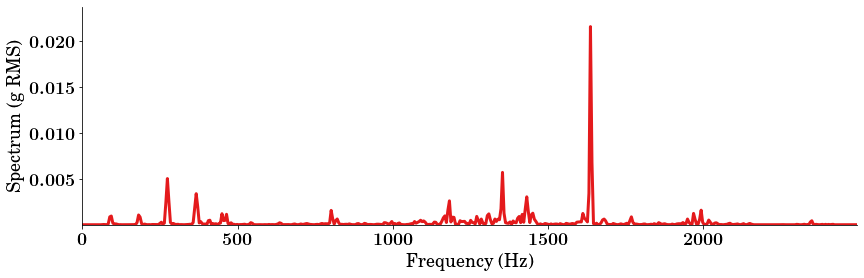

In [127]:
create_animation(fft_good[:,:512],freqs[:512])

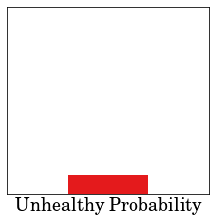

In [104]:
fig = plt.figure(figsize=(4,4))
bar = plt.bar(0, 0.1,color='#e41a1c')
plt.xlim(-1,1)
plt.ylim(0,1)
plt.xlabel('Unhealthy Probability')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelleft=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# plt.xticks(1, ('Bill', 'Fred', 'Mary', 'Sue'))
plt.show()


In [112]:
bar.patches[0].get_height()

0.5

In [130]:
def create_animation(data):
    

    fig = plt.figure(figsize=(4,4))
    bar = plt.bar(0, 0.1,color='#e41a1c')
    # Customize the axes
    ax = plt.gca()
    plt.xlim(-1,1)
    plt.ylim(0,1)
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.xlabel('Healthy Probability')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,
        labelleft=False,
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    # plt.xticks(1, ('Bill', 'Fred', 'Mary', 'Sue'))


    fps = 1
    
   

    def init():
        bar = plt.bar(0,0,color='#e41a1c')
        return bar
    def animate(i):
        bar.patches[0].set_height(data[i])
        
    

    anim = FuncAnimation(fig, animate, init_func=init,
                                   frames=data.shape[0], interval=fps)

    anim.save(
        '{}.mov'.format('Bad-Class-Anim'), # Set the file name
        dpi=180,          # Bump up to 4K resolution 3840x2160
        codec='png',
        bitrate=-1,
    #     writer=writer,
        fps=fps,
        savefig_kwargs={
                    'transparent': True, # h264 doesn't seem to like transparency 
                    'facecolor': 'none'})


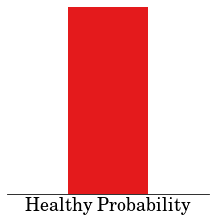

In [132]:
create_animation(class_bad)